# Gaussian Process Recurrent Neural Networks
- Here is the demo for learning latent true dynamics (lorenz dynamics) from high-dimensional gaussian data

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import tensorflow as tf
from edward.models import Normal, MultivariateNormalTriL
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys   
sys.setrecursionlimit(10000)
from tensorflow.contrib import slim
import funs

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.random.seed(12345)

/home/sheqi/.conda/envs/tensorflow1_5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Hyperparameters

In [2]:
H  = 15   # number of hidden units (larger may be worse, and select: 15)
L  = 3    # number of latents
D  = 100   # number of features
N  = 200  # number of time points
dt = 0.01 # temporal precision (smaller means slower change)

# Generating true dynamics and observations

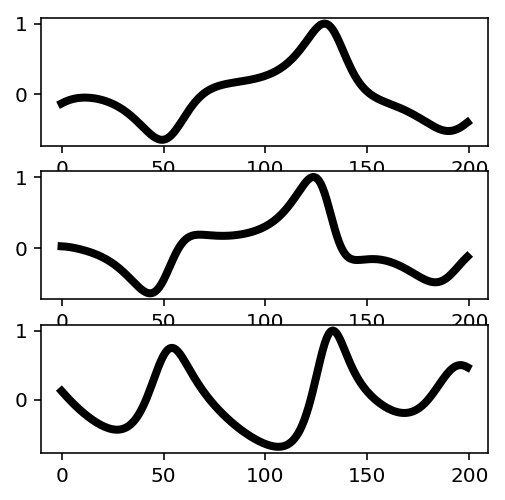

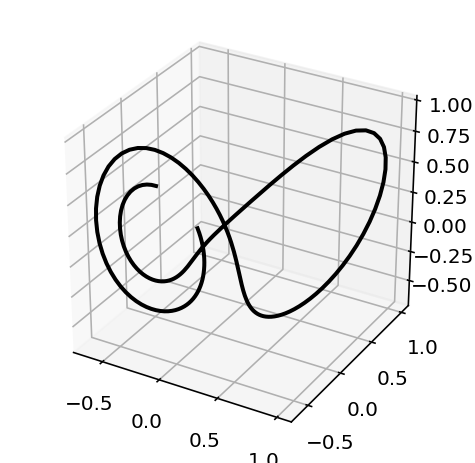

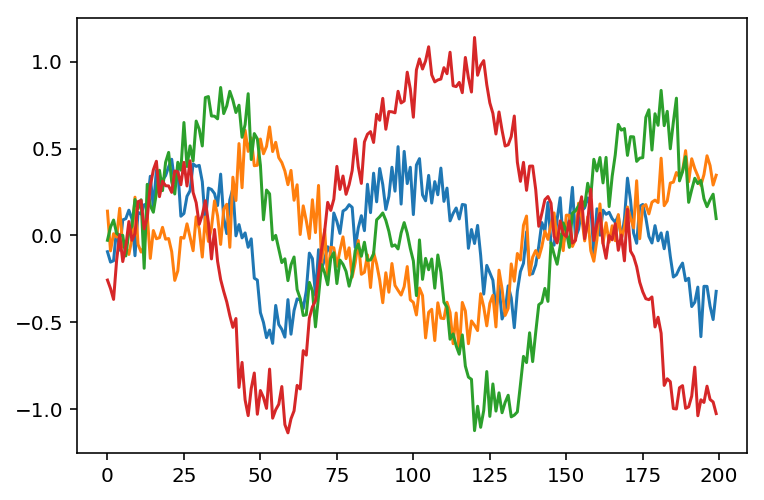

In [3]:
# true dynamics
z_true = np.zeros((N, 3))
z_all = funs.dyn_lorenz(4 * N, dt)
z_sim = z_all[-N:,:]

z_sim_norm = z_sim - z_sim.mean(axis=0)
z_sim_norm /= np.linalg.norm(z_sim_norm, axis=0, ord=np.inf)

z_true = z_sim_norm

# latent states mapping to observatios
# x_train = funs.map_sine(z_true, L, D)
# x_train = funs.map_tanh(z_true, L, D)
x_train = funs.map_sine(z_true, L, D)
x_train = x_train.astype(np.float32)

plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(z_true[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(z_true[:, 1], lw=4, color='k')

ax3 = plt.subplot(313, sharex=ax1)
ax3.plot(z_true[:, 2], lw=4, color='k')

plt.figure(figsize=(4, 4))
ax = plt.gca(projection='3d')
ax.plot(*z_true.T, lw = 2, color='k')

# Observatons 
plt.figure()
plt.plot(x_train[:,1:5]);

## Model-Part1:  dynamics

In [4]:
# Model
zt = Normal(loc=tf.zeros(L), scale=tf.ones(L))
ht = tf.constant(0, dtype=tf.float32, shape=[H])
ct = tf.constant(0, dtype=tf.float32, shape=[H])

c = [] 
h = []
z = []
mu = []
sig = []

reuse = None

for t in range(0, N):
    if t > 0:
        reuse = True
    #ht = funs.normal_cell(ht, zt, H)
    #ht = ar1_cell(ht, zt, name='ar1', reuse=reuse)
    #ht = rnn_cell(ht, zt, name="rnn", reuse=reuse)
    ht, ct = funs.lstm_cell(zt, ht, ct, name="lstm", reuse=reuse)
    h.append(ht)
    c.append(ct)
    zt = funs.encode_z(ht, L, name="encode_z", reuse=reuse)
    z.append(zt)

## Model-Part2: mapping

In [5]:
# GP mapping
z_1   = tf.stack(z,1)
z_all = tf.transpose(z_1, [1,0])

# kernel configuration (rbf)
l   = tf.nn.softplus(tf.Variable(2, dtype=tf.float32))    # length scale
rho = tf.nn.softplus(tf.Variable(2, dtype=tf.float32))    # marginal variance
nsevar  = tf.nn.softplus(tf.Variable(2, dtype=tf.float32))# noise variance
njitter = tf.constant(1e-6, dtype=tf.float32, shape=[N])  # jitter

kernel = funs.kernel_fun(z_all, lengthscale=l, variance=rho, name='rbf') + tf.eye(N)*nsevar
x = MultivariateNormalTriL(loc=tf.zeros([D, N]), scale_tril=tf.cholesky(kernel))

In [6]:
# # linear mapping
# Wx = tf.Variable(np.zeros([L, D]), dtype=tf.float32) # weights of mapping
# bx = tf.Variable(np.zeros(D), dtype=tf.float32)      # bias of mapping 
# z_1 = tf.stack(z,1)
# #mu  = tf.nn.bias_add(tf.matmul(z_1, Wx, transpose_a=True), bx)
# mu  = tf.matmul(z_1, Wx, transpose_a=True)

# sig = 0.1
# x = Normal(loc=tf.transpose(mu), scale=sig)

# Variational Inference

In [7]:
# Mean field Variational Inference
qz = []

with tf.name_scope("posterior"):
    for t in range(0, N):
        qz0 = Normal(loc=tf.Variable(tf.zeros(L)), scale=tf.nn.softplus(tf.Variable(tf.ones(L))))
        qz.append(qz0)

pairlist = dict(zip(z, qz))

inference = ed.KLqp(pairlist, data={x: x_train.T})
optimizer = tf.train.RMSPropOptimizer(0.01, epsilon=1.0)
inference.initialize(optimizer=optimizer)

tf.global_variables_initializer().run()
inference.run(n_iter=1000, n_print=100, n_samples=10, logdir='log/rnn_gplvm')

/home/sheqi/.conda/envs/tensorflow1_5/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


1000/1000 [100%] ██████████████████████████████ Elapsed: 960s | Loss: -13197.369


# Bi-LSTM Inference Network

In [10]:
#  Mean field - bi-LSTM Varitonal inference
# qz = []
# qc_l = [] 
# qh_l = []
# qc_r = []
# qc_r = []

# H1 = 5

# qh_l = tf.constant(0, dtype=tf.float32, shape=[H1])
# qc_l = tf.constant(0, dtype=tf.float32, shape=[H1])

# qh_r = tf.constant(0, dtype=tf.float32, shape=[H1])
# qc_r = tf.constant(0, dtype=tf.float32, shape=[H1])

# W_ur =  tf.Variable(np.zeros([H1, L]), dtype=tf.float32)
# W_sigr = tf.Variable(np.zeros([H1, L]), dtype=tf.float32)
# W_ul = tf.Variable(np.zeros([H1, L]), dtype=tf.float32)
# W_sigl = tf.Variable(np.zeros([H1, L]), dtype=tf.float32)

# b_ur = tf.Variable(np.zeros(L), dtype=tf.float32)
# b_sigr = tf.Variable(np.zeros(L), dtype=tf.float32)
# b_ul = tf.Variable(np.zeros(L), dtype=tf.float32)
# b_sigl = tf.Variable(np.zeros(L), dtype=tf.float32)

# x_ph = tf.placeholder(tf.float32, [N, D])

# reuse = None
# qh_l_all = []
# qh_r_all = []

# with tf.name_scope("hidden"):
#     for t in range(0, N):
#         if t > 0:
#             reuse = True
#         qh_l, qc_l = funs.lstm_cell_1(x_ph[t], qh_l, qc_l, name="lstm_1", reuse=reuse)
#         qh_r, qc_r = funs.lstm_cell_2(x_ph[N-t-1], qh_r, qc_r, name="lstm_2", reuse=reuse)
        
#         qh_l_all.append(qh_l)
#         qh_r_all.append(qh_r)

# with tf.name_scope("posterior"):
#     for t in range(0, N):
#         # MF-LR 
#         if t > 0:
#             reuse = True
            
#         u_l = ed.dot(qh_l_all[t], W_ul) + b_ul
#         u_r = ed.dot(qh_r_all[N-1-t], W_ur) + b_ur
        
#         sig_l = tf.nn.softplus(ed.dot(qh_l_all[t], W_sigl) + b_sigl)
#         sig_r = tf.nn.softplus(ed.dot(qh_r_all[N-1-t], W_sigr) + b_sigr)
        
#         u_lr = tf.div(tf.multiply(u_l, sig_r) + tf.multiply(u_r, sig_l), sig_l + sig_r)
#         sig_lr = tf.div(tf.multiply(sig_l, sig_r), sig_l + sig_r)
            
#         qz0 = Normal(loc=u_lr, scale=sig_lr)
#         qz.append(qz0)

In [11]:
# pairlist = dict(zip(z, qz))

# inference = ed.KLqp(pairlist, data={x: x_train.T})
# optimizer = tf.train.RMSPropOptimizer(0.01, epsilon=1.0)
# inference.initialize(optimizer=optimizer)

# tf.global_variables_initializer().run()
# inference.run(n_iter=1000, n_print=100, n_samples=10, logdir='log/rnn_gplvm')

# Varitional Autoencoder

In [12]:
# VAE: recognition model
# qz = []

# with tf.name_scope("posterior"):
#      for t in range(0, N):
#         hidden = slim.fully_connected(tf.expand_dims(x_train[t],0), D, activation_fn=tf.nn.relu)
#         qz0 = Normal(loc=tf.squeeze(slim.fully_connected(hidden, L),0), 
#                      scale=tf.squeeze(slim.fully_connected(hidden, L, activation_fn=tf.nn.softplus),0))
#         qz.append(qz0)

# pairlist = dict(zip(z, qz))
# inference = ed.KLqp(pairlist, data={x: x_train.T})
# optimizer = tf.train.RMSPropOptimizer(0.01, epsilon=1.0)
# inference.initialize(optimizer=optimizer)

# tf.global_variables_initializer().run()
# inference.run(n_iter=1000, n_print=100, n_samples=10, logdir='log/rnn_gplvm')

# Dynamics recovery performance 

In [8]:
sess = ed.get_session()

qz_mean = []
qz_var = []

for qz_i in qz:
    qz_mean.append(qz_i.mean())
    qz_var.append(qz_i.variance())
    
qz_mean_est = sess.run(qz_mean,feed_dict={x: x_train.T})
qz_var_est = sess.run(qz_var,feed_dict={x: x_train.T})

In [9]:
# hyperparameters: GP mapping
l_est,rho_est,nsevar_est = sess.run([l,rho,nsevar],feed_dict={x: x_train.T})

print(l_est)
print(rho_est)
print(nsevar_est)

5.2654448
0.40183425
0.009828508


In [10]:
# hyperparameters: linear mapping
# Wx_est = sess.run([Wx],feed_dict={x: x_train.T})

# 3D visualization

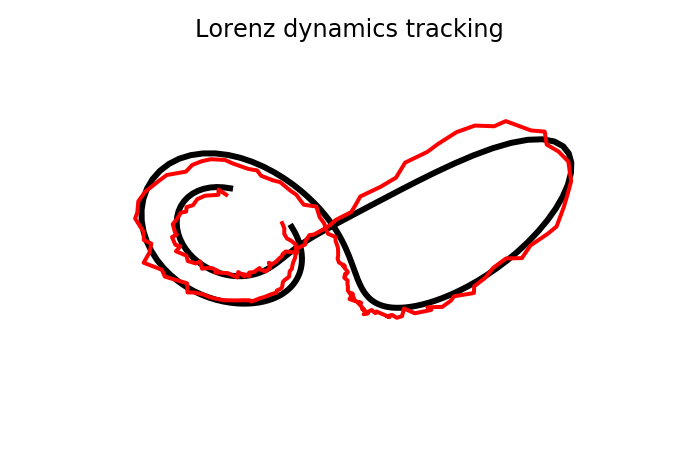

In [11]:
# match and normalization
qz_est_norm = np.stack(qz_mean_est)/np.linalg.norm(np.stack(qz_mean_est))
z_true_c = z_true - z_true.mean(axis=0)
z_true_norm = z_true_c/np.linalg.norm(z_true_c)

R = funs.compute_optimal_rotation(np.stack(qz_est_norm), z_true_norm, scale=True)
qz_est_norm_R = np.stack(qz_est_norm).dot(R)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(z_true_norm[:,0], z_true_norm[:,1], z_true_norm[:,2], lw=3, color = 'k')
ax.plot(qz_est_norm_R[:,0], qz_est_norm_R[:,1], qz_est_norm_R[:,2], lw=2, color = 'r')

ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz dynamics tracking")
ax.set_axis_off()

# Each dimension comparison

Text(0.5, 1.0, '3rd dimension')

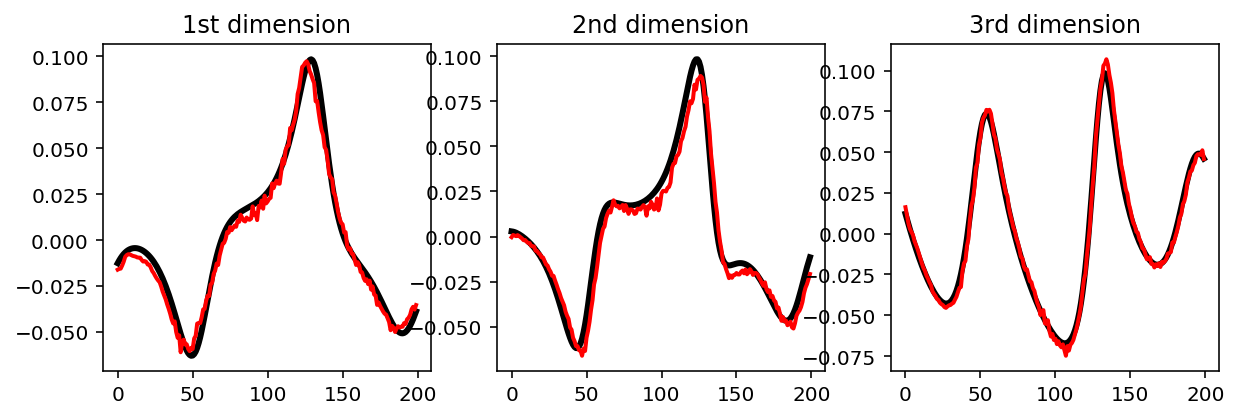

In [12]:
# each dimension matching
f, axs = plt.subplots(1,3,figsize=(10,3))
axs[0].plot(z_true_norm[:,0], lw=3, color='k');
axs[0].plot(qz_est_norm_R[:,0], lw=2, color='r');
axs[0].set_title('1st dimension')
#axs[0].set_axis_off()

axs[1].plot(z_true_norm[:,1], lw=3, color='k');
axs[1].plot(qz_est_norm_R[:,1], lw=2, color='r');
axs[1].set_title('2nd dimension')
#axs[1].set_axis_off()

axs[2].plot(z_true_norm[:,2], lw=3, color='k');
axs[2].plot(qz_est_norm_R[:,2], lw=2, color='r');
axs[2].set_title('3rd dimension')
#axs[2].set_axis_off()

In [13]:
# Mean square error
np.sqrt(((z_true_norm - qz_est_norm_R) ** 2).mean(axis=None))

0.005656991066082818

# Criticism 

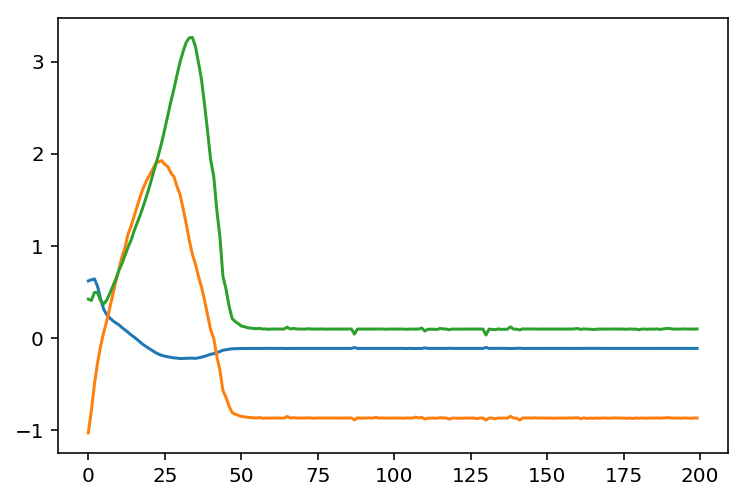

In [14]:
# test LSTM dynamics
# prior over latent states
pz_mean = []
pz_var = []

for pz_i in z:
    pz_mean.append(pz_i.mean())
    pz_var.append(pz_i.variance())
    
pz_mean_est = sess.run(pz_mean,feed_dict={x: x_train.T})
pz_var_est = sess.run(pz_var,feed_dict={x: x_train.T})

pz_all_est = np.asarray(pz_mean_est)
plt.plot(pz_all_est);

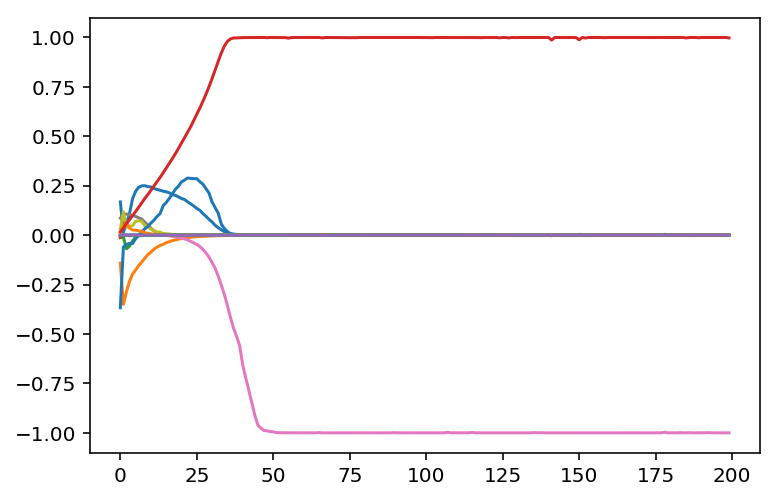

In [15]:
# hidden state
h_all_est = sess.run(h, feed_dict={x: x_train.T})
h_all_est = np.asarray(h_all_est)
plt.plot(h_all_est);

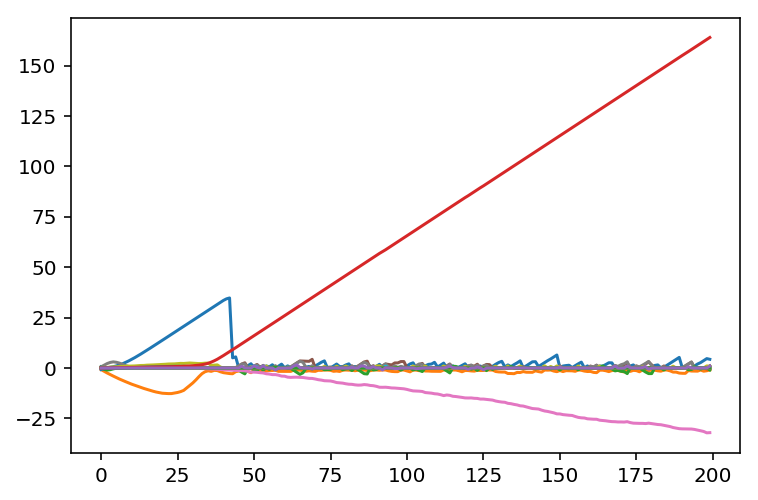

In [16]:
# cell state (only for LSTM cell)
c_all_est = sess.run(c, feed_dict={x: x_train.T})
c_all_est = np.asarray(c_all_est)
plt.plot(c_all_est);